# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [11]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$ \nabla_w L(w, {w_0}) =  \sum_{i=1}^{N} (\sigma(w^\top x_i) - y_i) x_i + \gamma  w + 2 \beta w $\
$ \nabla_{w_0} L(w, {w_0}) = \sum_{i = 1}^{N} (\sigma(w^\top x_i - y_i))$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [12]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    linear_model = np.dot(X, w)
    predictions = 1/(1 + np.exp(-linear_model))
    loss = -np.sum(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15)) / X.shape[0]
    loss += beta * 0.5 * np.sum(w ** 2)
    return loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [13]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    predictions = 1/(1 + np.exp(-X @ w))
    grad_w =   X.T @ (predictions - y) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 =  np.sum(predictions - y)
    return grad_w.tolist(), grad_w0

#### Check yourself

In [6]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)[0]
assert(np.allclose(grad_w,
                  [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                  rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [102]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = 0
        self.classes_ = None
    def _initialize_weights(self, n_features):
        np.random.seed(self.random_state)
        self.w = np.random.randn(n_features)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def get_grad(self, X, y, w: List[float], gamma=1.0, beta=1.0) -> Tuple[List[float], float]:
        N, D = X.shape
        w = np.array(w)
        predictions = self._sigmoid(np.dot(X, self.w))
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)
        grad_w = X.T @ (predictions - y) / N + gamma * np.sign(w) + 2 * beta * w
        grad_w0 = np.sum(predictions - y) / N
        return grad_w.tolist(), grad_w0

    def fit(self, X, y):
        if not isinstance(X, np.ndarray):
          X = X.toarray()
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        self._initialize_weights(n_features)
        self.history_ = []
        for iteration in range(self.max_iter):
            grad_w, grad_w0 = self.get_grad(X, y, self.w, self.gamma, self.beta)
            self.w -= self.lr * np.array(grad_w)
            self.w0 -= self.lr * grad_w0
            predictions = self._sigmoid(np.dot(X, self.w) + self.w0)
            loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
            loss += self.gamma * np.sum(np.abs(self.w)) + 0.5 * self.beta * np.sum(self.w ** 2)
            self.history_.append(loss)
            if np.linalg.norm(grad_w) < self.tolerance and abs(grad_w0) < self.tolerance:
                print(f"Converged after {iteration + 1} iterations.")
                break
        return self

    def predict(self, X):
      if not isinstance(X, np.ndarray):
        X = X.toarray()
      proba = self.predict_proba(X)
      return np.argmax(proba, axis=1) 

    def predict_proba(self, X):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        z = np.dot(X, self.w)
        return np.vstack([1-(1 / (1 + np.exp(-z))), 1 / (1 + np.exp(-z))]).T

In [103]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [104]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

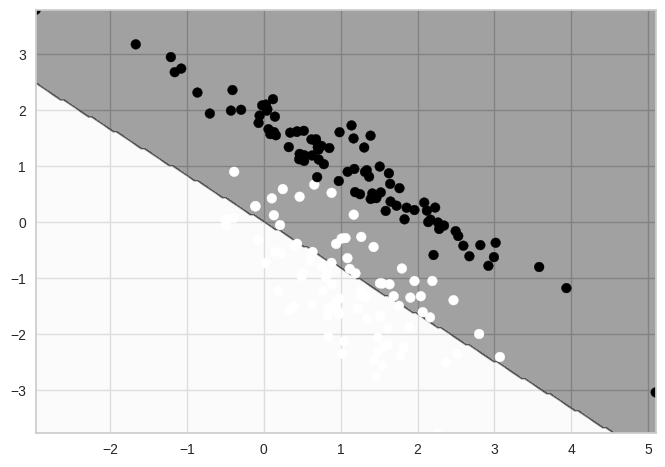

In [105]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

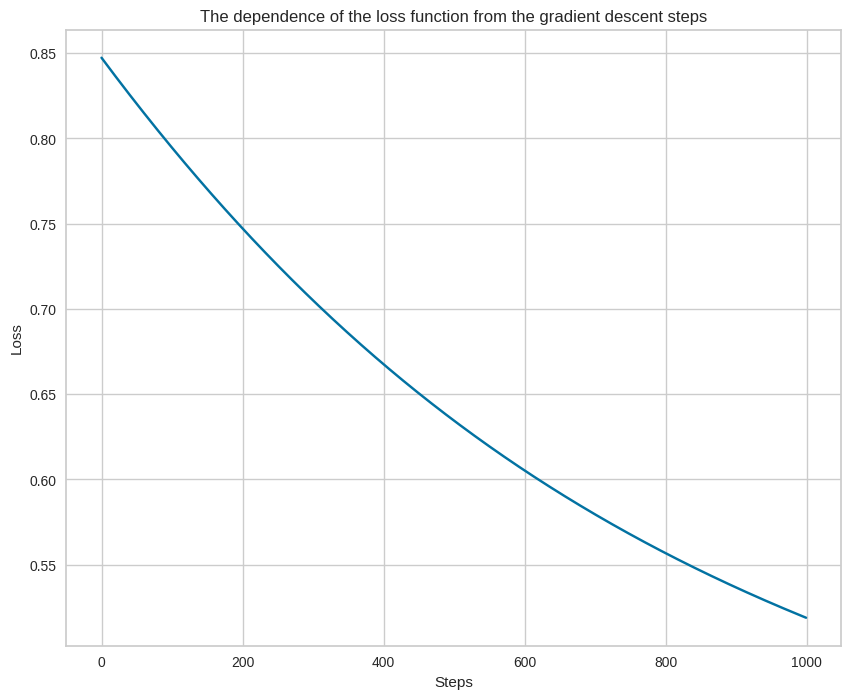

In [106]:
plt.figure(figsize=(10, 8))
plt.plot(model.history_, linestyle='-', markersize=4)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('The dependence of the loss function from the gradient descent steps')
plt.grid(True)
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

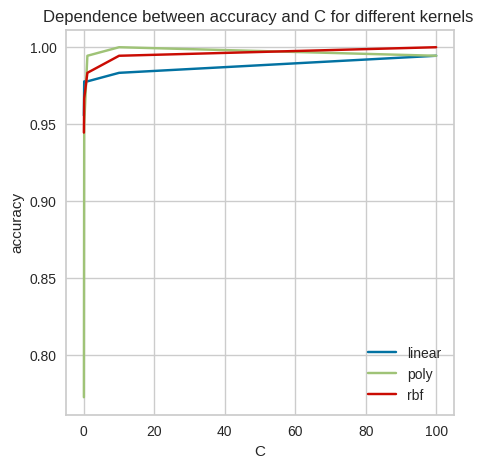

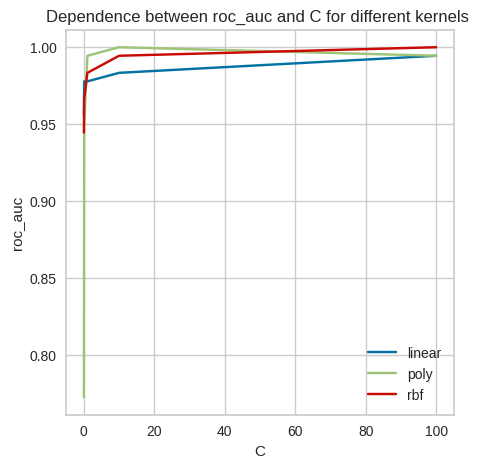

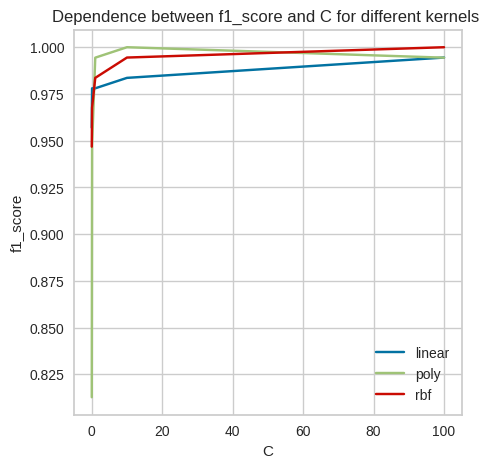

In [107]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
kernels = ["linear", "poly", "rbf"]
cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1, 10]
degrees = [0, 1, 2, 3, 4]
metrics = ["accuracy", "roc_auc", "f1_score"]

def plot_dependency(metric):
  plt.figure(figsize=(5, 5))
  for kernel in kernels:
    metrics = []
    for c in cs:
      model = SVC(kernel=kernel, C=c)
      model.fit(X, y)
      predict = model.predict(X)
      if metric=="accuracy":
        metrics.append(accuracy_score(y, predict))
      elif metric=="roc_auc":
        metrics.append(roc_auc_score(y, predict))
      else:
        metrics.append(f1_score(y, predict))
    plt.plot(cs, metrics, linestyle='-', markersize=4, label=kernel)
    plt.xlabel('C')
    plt.ylabel(metric)
    plt.title("Dependence between " + metric +" and C for different kernels ")
    plt.legend()
  plt.show()
for metric in metrics:
  plot_dependency(metric)


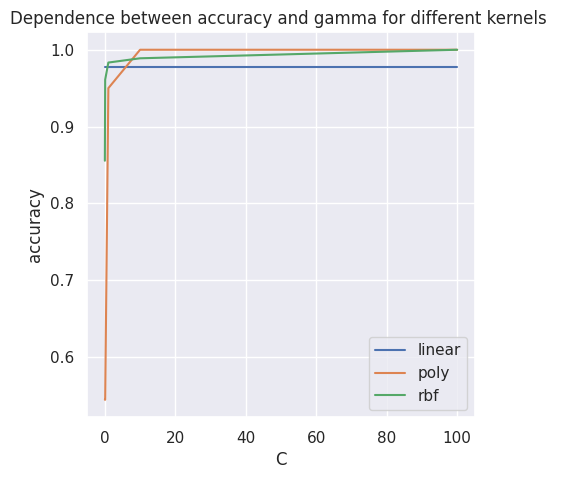

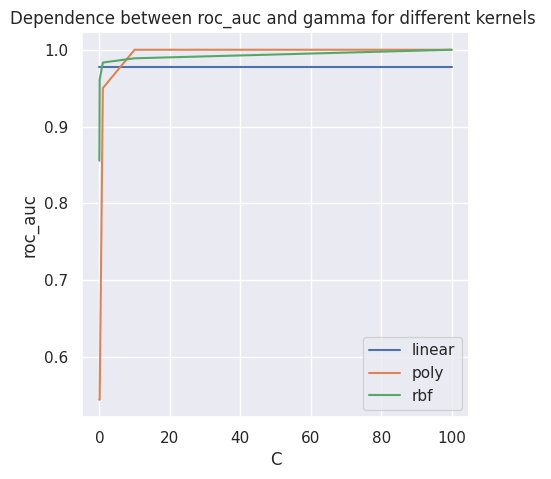

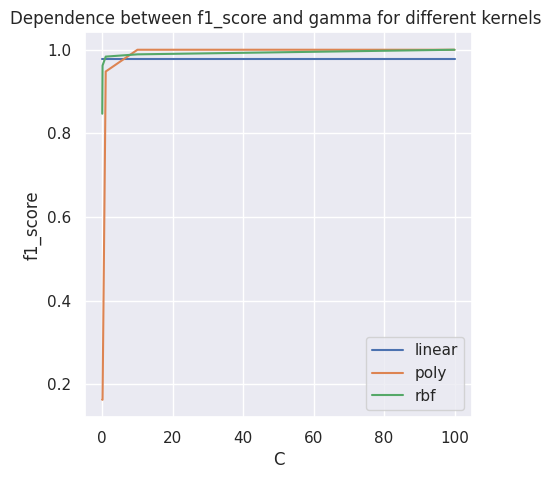

In [ ]:
def plot_dependency(metric):
  plt.figure(figsize=(5, 5))
  for kernel in kernels:
    metrics = []
    for gamma in gammas:
      model = SVC(kernel=kernel, gamma=gamma)
      model.fit(X, y)
      predict = model.predict(X)
      if metric=="accuracy":
        metrics.append(accuracy_score(y, predict))
      elif metric=="roc_auc":
        metrics.append(roc_auc_score(y, predict))
      else:
        metrics.append(f1_score(y, predict))
    plt.plot(cs, metrics, linestyle='-', markersize=4, label=kernel)
    plt.xlabel('C')
    plt.ylabel(metric)
    plt.title("Dependence between " + metric + " and gamma for different kernels ")
    plt.legend()
  plt.show()
for metric in metrics:
  plot_dependency(metric)

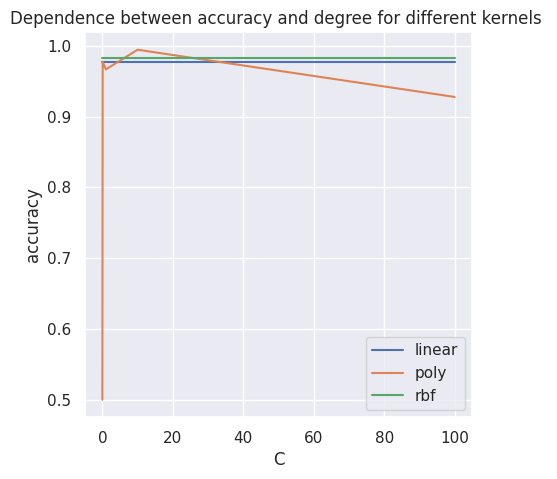

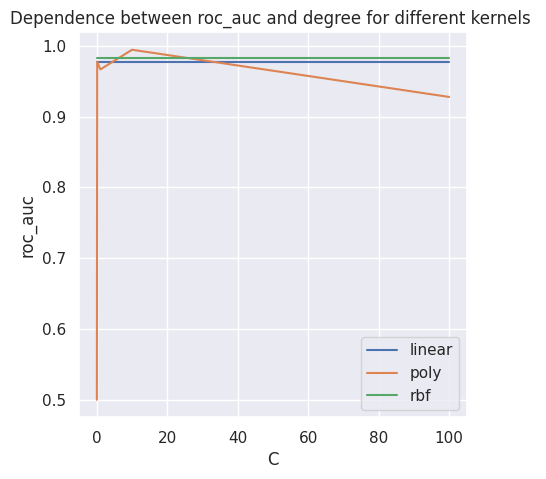

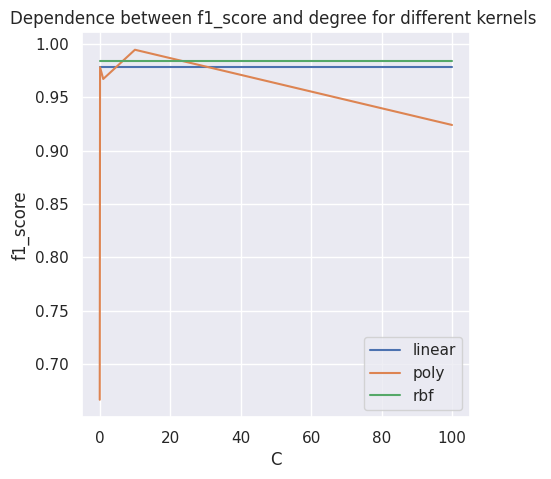

In [ ]:
def plot_dependency(metric):
  plt.figure(figsize=(5, 5))
  for kernel in kernels:
    metrics = []
    for degree in degrees:
      model = SVC(kernel=kernel, degree=degree)
      model.fit(X, y)
      predict = model.predict(X)
      if metric=="accuracy":
        metrics.append(accuracy_score(y, predict))
      elif metric=="roc_auc":
        metrics.append(roc_auc_score(y, predict))
      else:
        metrics.append(f1_score(y, predict))
    plt.plot(cs, metrics, linestyle='-', markersize=4, label=kernel)
    plt.xlabel('C')
    plt.ylabel(metric)
    plt.title("Dependence between " + metric + " and degree for different kernels ")
    plt.legend()
  plt.show()
for metric in metrics:
  plot_dependency(metric)


1) How sensitive are kernels to hyperparameters?
Linear Kernel: Less sensitive overall, primarily to C.
Polynomial Kernel: Sensitive to C, degree, and gamma. Prone to overfitting with high degree and C.
RBF Kernel: Extremely sensitive to C and gamma. Prone to overfitting with large gamma.
2)  How sensitive is a solution to the regularization?
C is crucial for controlling overfitting in all kernels. Too large a C increases the risk of overfitting, especially in the RBF and polynomial kernels.
3) Which kernel is prone to overfitting?
Polynomial and RBF kernels are more prone to overfitting due to their ability to create highly flexible decision boundaries.
Linear kernel is less likely to overfit unless C is too large


## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [18]:
import re,os
import string
import nltk
import string
string.punctuation
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')
authors = {
    "Чехов":5000,
    "Достоевский": 15000,
    "Гоголь":8000,
    "Горький":11000,
    "Толстой":20000,
    "Тургенев":3000
}
def create_dataset(directory_path):
    data = []
    for author in authors.keys():
        author_path = os.path.join(directory_path, author)
        if os.path.exists(author_path) and os.path.isdir(author_path):
            for filename in os.listdir(author_path):
                if filename.endswith('.txt'):
                    file_path = os.path.join(author_path, filename)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        sentences = re.split(r'(?<!\w\.\w.)(?<![А-Я][а-я]\.)(?<=\.|\?)\s', file.read())
                        data.extend([(sentence.strip(), author) for sentence in sentences if sentence.strip()])
    return pd.DataFrame(data, columns=['sentence', 'author'])

dataset = create_dataset('data')
dataset = dataset[dataset['sentence'].apply(lambda x: len(x.split()) >= 15)]
dataset.reset_index(drop=True, inplace=True)
data = []

for author, count in authors.items():
    author_data = dataset[dataset["author"] == author]  # Фильтруем строки по автору
    sampled_data = author_data.sample(n=count, random_state=42, replace=False)  # Выбираем строки
    data.append(sampled_data)

dataset = pd.concat(data)
dataset.reset_index(drop=True, inplace=True)
dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentence,author
0,"Лицо было озабочено, сосредоточено, сжато в ск...",Чехов
1,"Эх, кабы знатье, барин, что вы придете, не вел...",Чехов
2,Надо также бросить эту манеру ссылаться на физ...,Чехов
3,"Она тоже поднялась и, глядя прямо в лицо Ивана...",Чехов
4,"Если кто из товарищей опаздывал на молебен, ил...",Чехов
...,...,...
61995,"Там, где ему приходилось перескочить ее – и гд...",Тургенев
61996,"Въезжая в эти выселки, мы не встретили ни одно...",Тургенев
61997,"Правильные черты лица, большие темные глаза, т...",Тургенев
61998,Весть о кончине Чертопханова каким-то образом ...,Тургенев


In [19]:

from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stopwords = nltk.corpus.stopwords.words('russian')
def tokenization(text):
    word_tokenizer = nltk.WordPunctTokenizer()
    tokens = word_tokenizer.tokenize(text)
    return tokens

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

def lemmatizer(text):
  stemmer = SnowballStemmer("russian")
  lemmatized_words = [stemmer.stem(word) for word in text]
  return lemmatized_words

dataset['prep_text'] = dataset['sentence'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', '', x)).apply(lambda x: x.lower())
dataset['tokens'] = dataset['prep_text'].apply(lambda x: tokenization(x))
dataset['swr'] = dataset['tokens'].apply(lambda x: remove_stopwords(x))
dataset['lemmatized'] = dataset['swr'].apply(lambda x: lemmatizer(x))
dataset['sentence'] = dataset['lemmatized'].apply(lambda x: ' '.join(x))
dataset

,sentence,author,prep_text,tokens,swr,lemmatized
0,лиц озабоч сосредоточ сжат складк человек знак...,Чехов,лицо было озабочено сосредоточено сжато в скла...,"[лицо, было, озабочено, сосредоточено, сжато, ...","[лицо, озабочено, сосредоточено, сжато, складк...","[лиц, озабоч, сосредоточ, сжат, складк, челове..."
1,эх каб знат барин придет велел нынч баб сюд пр...,Чехов,эх кабы знатье барин что вы придете не велел б...,"[эх, кабы, знатье, барин, что, вы, придете, не...","[эх, кабы, знатье, барин, придете, велел, нынч...","[эх, каб, знат, барин, придет, велел, нынч, ба..."
2,такж брос манер ссыла физиолог беремен род воп...,Чехов,надо также бросить эту манеру ссылаться на физ...,"[надо, также, бросить, эту, манеру, ссылаться,...","[также, бросить, манеру, ссылаться, физиологию...","[такж, брос, манер, ссыла, физиолог, беремен, ..."
3,подня гляд прям лиц ива алексеич стал говор бы...,Чехов,она тоже поднялась и глядя прямо в лицо ивана ...,"[она, тоже, поднялась, и, глядя, прямо, в, лиц...","[поднялась, глядя, прямо, лицо, ивана, алексеи...","[подня, гляд, прям, лиц, ива, алексеич, стал, ..."
4,товарищ опаздыва молеб доход слух какойнибуд п...,Чехов,если кто из товарищей опаздывал на молебен или...,"[если, кто, из, товарищей, опаздывал, на, моле...","[товарищей, опаздывал, молебен, доходили, слух...","[товарищ, опаздыва, молеб, доход, слух, какойн..."
...,...,...,...,...,...,...
61995,приход перескоч полтор год том назад действите...,Тургенев,там где ему приходилось перескочить ее и где ...,"[там, где, ему, приходилось, перескочить, ее, ...","[приходилось, перескочить, полтора, года, тому...","[приход, перескоч, полтор, год, том, назад, де..."
61996,въезж выселк встрет одн жив душ куриц видн ули...,Тургенев,въезжая в эти выселки мы не встретили ни одной...,"[въезжая, в, эти, выселки, мы, не, встретили, ...","[въезжая, выселки, встретили, одной, живой, ду...","[въезж, выселк, встрет, одн, жив, душ, куриц, ..."
61997,правильн черт лиц больш темн глаз тонк губ сви...,Тургенев,правильные черты лица большие темные глаза тон...,"[правильные, черты, лица, большие, темные, гла...","[правильные, черты, лица, большие, темные, гла...","[правильн, черт, лиц, больш, темн, глаз, тонк,..."
61998,вест кончин чертопханов какимт образ дошл жид ...,Тургенев,весть о кончине чертопханова какимто образом д...,"[весть, о, кончине, чертопханова, какимто, обр...","[весть, кончине, чертопханова, какимто, образо...","[вест, кончин, чертопханов, какимт, образ, дош..."


In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
counter_vectorizer = CountVectorizer()
cv_output = counter_vectorizer.fit_transform(dataset['sentence'])
print(cv_output.todense()[:2])
tf_idf_vectorizer = TfidfVectorizer()
tf_output = tf_idf_vectorizer.fit_transform(dataset['sentence'])
print(tf_output.todense()[:2])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Output vectorized by bag of words is a table where
rows represent texts, columns represent words. The intersection of the columns and rows are integers. If there is a number 5 at the intersection of a row and a column, it means that the given word occurs 5 times in the given text.
Output by TF-IDF is the same table but scaled to the rarity of the word in the document set, and the intersection of rows and columns are values in interval from 0 to 1.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


(array([5000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

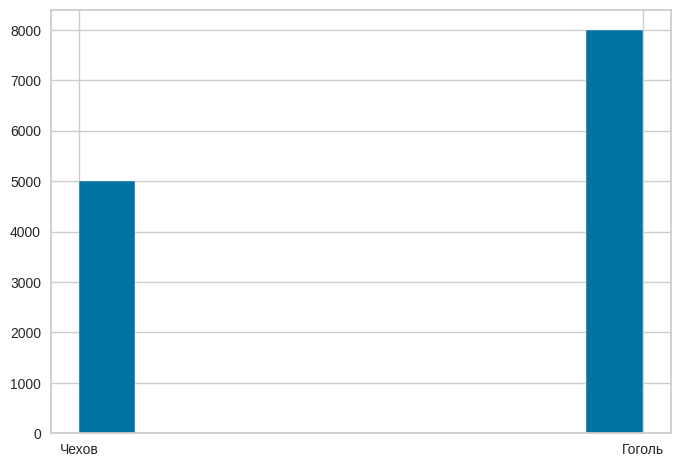

In [108]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from yellowbrick.target import ClassBalance
from sklearn import preprocessing
selected_authors = dataset.loc[dataset['author'].isin(["Чехов", "Гоголь"])]
selected_authors.reset_index(drop=True, inplace=True)
plt.hist(selected_authors['author'])

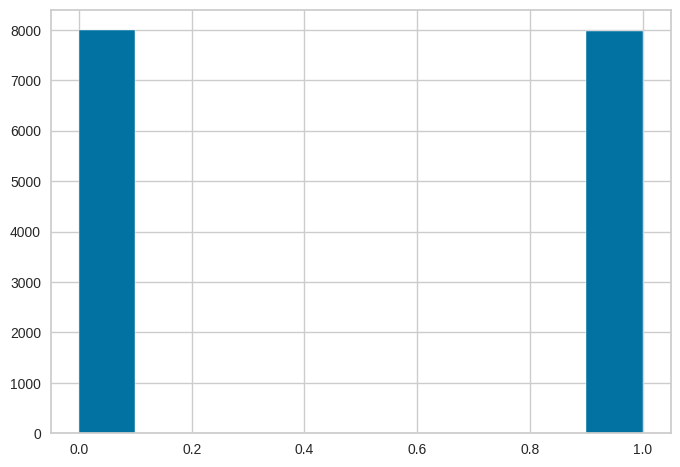

In [109]:
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
adasyn = ADASYN()
X = tf_idf_vectorizer.fit_transform(selected_authors['sentence'])
y = LabelEncoder().fit_transform(selected_authors['author'])
X_resampled, y_resampled = adasyn.fit_resample(X, y)
plt.hist(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

GridSerach for SVC

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1, 10, 100]}
svr = SVC(probability=True, verbose = False)
clf_svc = GridSearchCV(svr, parameters, scoring = 'f1', verbose=2, cv=2)
clf_svc.fit(X_train, y_train)
print("Best parameters: ", clf_svc.best_params_)
print("Best F1 score: ", clf_svc.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END .............................C=0.001, kernel=linear; total time=  40.6s
[CV] END .............................C=0.001, kernel=linear; total time=  40.9s
[CV] END ................................C=0.001, kernel=rbf; total time=  42.6s
[CV] END ................................C=0.001, kernel=rbf; total time=  42.7s
[CV] END ...............................C=0.001, kernel=poly; total time=  41.2s
[CV] END ...............................C=0.001, kernel=poly; total time=  40.9s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  42.4s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  42.6s
[CV] END ..............................C=0.01, kernel=linear; total time=  41.4s
[CV] END ..............................C=0.01, kernel=linear; total time=  41.4s
[CV] END .................................C=0.01, kernel=rbf; total time=  43.0s
[CV] END .................................C=0.01

Below GridSearchCV for Logit

In [58]:
parameters = {"gamma": [0.01, 0.1, 0.2, 0.3, 1.0],
              "beta": [0.01, 0.1, 0.2, 0.3, 1.0],
              }
logitModel = Logit()
clf = GridSearchCV(logitModel, parameters, scoring='f1', verbose=2, cv=2)
clf.fit(X_train, y_train)
print("Best parameters: ", clf.best_params_)
print("F1 score: ", clf.best_score_)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END ..............................beta=0.01, gamma=0.01; total time=  29.1s
[CV] END ..............................beta=0.01, gamma=0.01; total time=  29.1s
[CV] END ...............................beta=0.01, gamma=0.1; total time=  29.4s
[CV] END ...............................beta=0.01, gamma=0.1; total time=  29.4s
[CV] END ...............................beta=0.01, gamma=0.2; total time=  29.5s
[CV] END ...............................beta=0.01, gamma=0.2; total time=  29.4s
[CV] END ...............................beta=0.01, gamma=0.3; total time=  29.7s
[CV] END ...............................beta=0.01, gamma=0.3; total time=  29.6s
[CV] END ...............................beta=0.01, gamma=1.0; total time=  29.7s
[CV] END ...............................beta=0.01, gamma=1.0; total time=  29.4s
[CV] END ...............................beta=0.1, gamma=0.01; total time=  29.3s
[CV] END ...............................beta=0.1

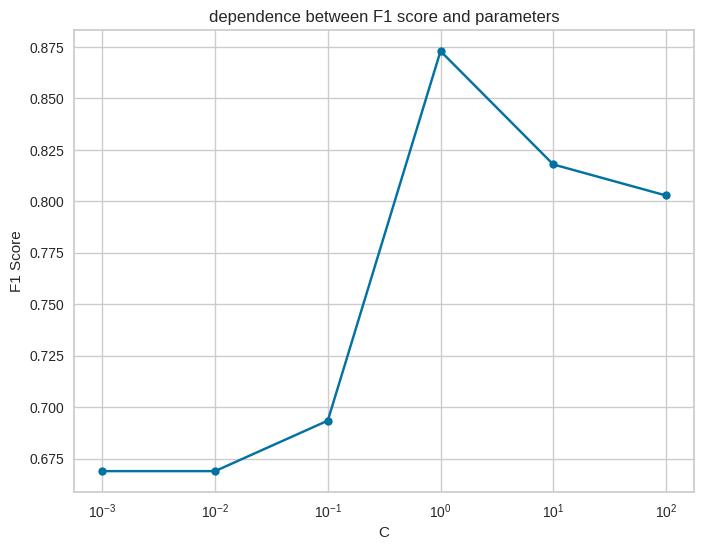

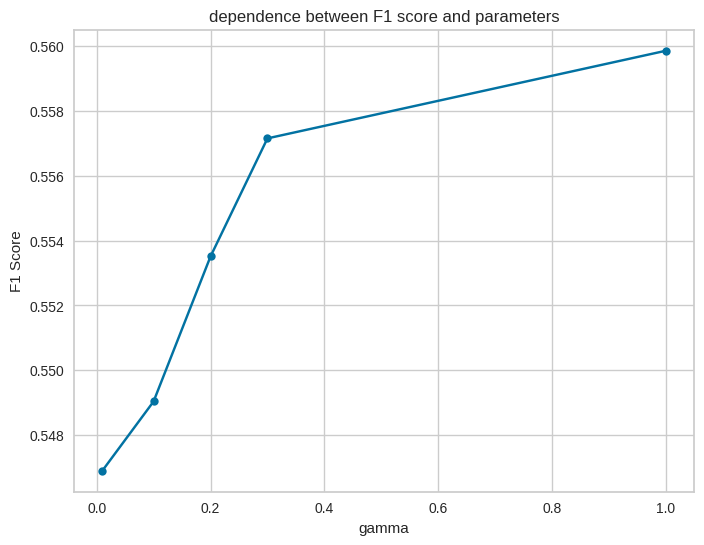

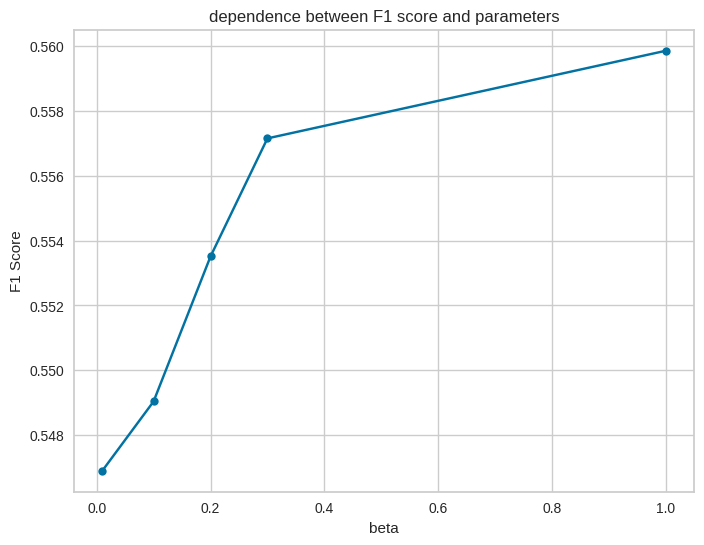

In [117]:
results = clf_svc.cv_results_
unique_C_values = np.unique(results['param_C'].data)
mean_f1_scores = [np.mean(results['mean_test_score'][results['param_C'] == c]) for c in unique_C_values]
plt.figure(figsize=(8, 6))
plt.plot(unique_C_values, mean_f1_scores, marker='o', color='b', linestyle='-', markersize=6)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.title('dependence between F1 score and parameters')
plt.show()

results_2 = clf.cv_results_
unique_C_values_2 = np.unique(results_2['param_gamma'].data)
mean_f1_scores_2 = [np.mean(results_2['mean_test_score'][results_2['param_gamma'] == c]) for c in unique_C_values_2]
plt.figure(figsize=(8, 6))
plt.plot(unique_C_values_2, mean_f1_scores_2, marker='o', color='b', linestyle='-', markersize=6)
plt.xlabel('gamma')
plt.ylabel('F1 Score')
plt.title('dependence between F1 score and parameters')
plt.show()

unique_C_values_3 = np.unique(results_2['param_beta'].data)
mean_f1_scores_3 = [np.mean(results_2['mean_test_score'][results_2['param_gamma'] == c]) for c in unique_C_values_3]
plt.figure(figsize=(8, 6))
plt.plot(unique_C_values_3, mean_f1_scores_3, marker='o', color='b', linestyle='-', markersize=6)
plt.xlabel('beta')
plt.ylabel('F1 Score')
plt.title('dependence between F1 score and parameters')
plt.show()

In [51]:
from sklearn.metrics import *
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
labels = ['negative','positive']
def show_confusion_matrix(y_test, pred,title):
        sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.show()

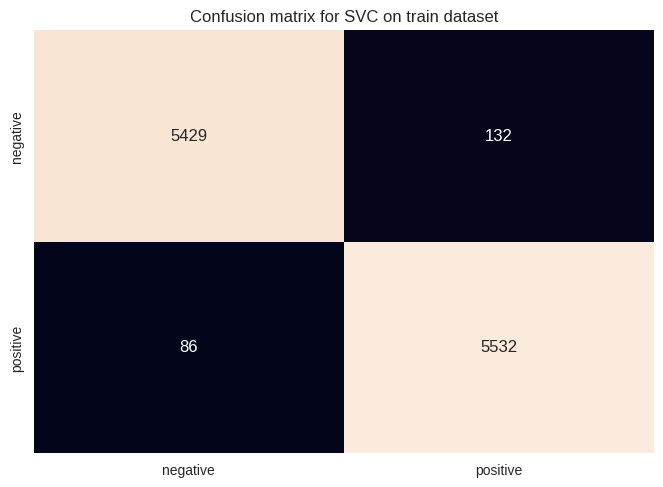

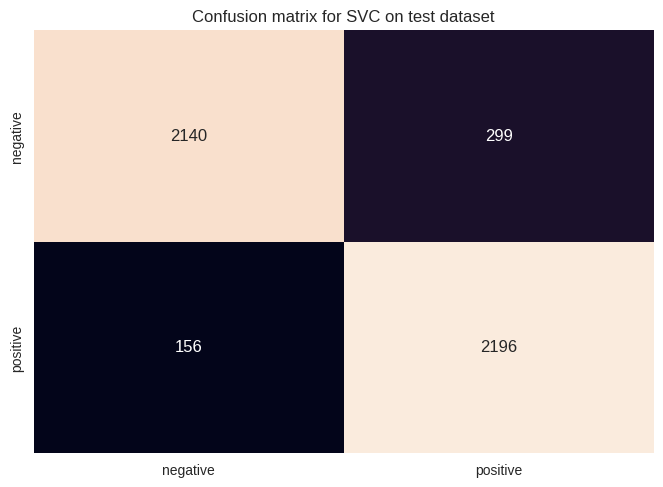

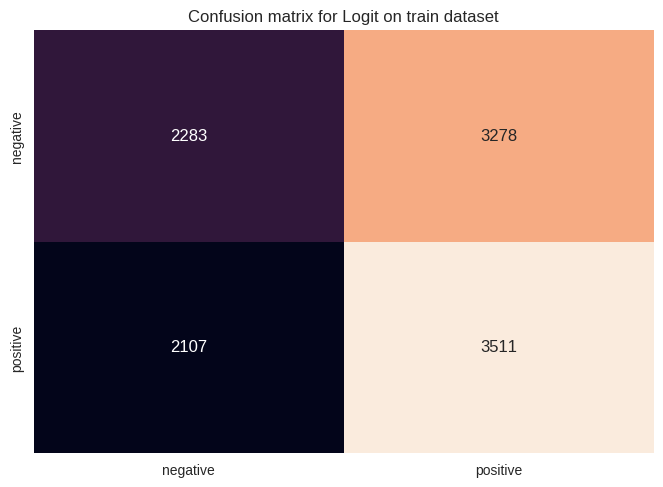

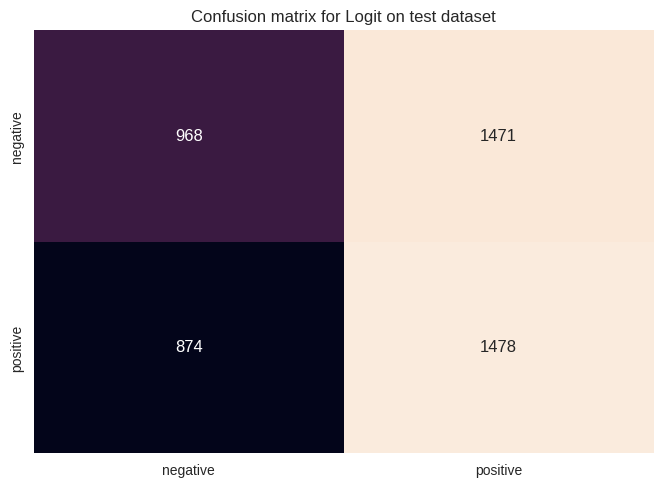

In [118]:
show_confusion_matrix(y_train, clf_svc.predict(X_train), "Confusion matrix for SVC on train dataset")
show_confusion_matrix(y_test, clf_svc.predict(X_test), "Confusion matrix for SVC on test dataset")
show_confusion_matrix(y_train, clf.predict(X_train), "Confusion matrix for Logit on train dataset")
show_confusion_matrix(y_test, clf.predict(X_test), "Confusion matrix for Logit on test dataset")

In [121]:
print("Metrics for SVC")
show_results(y_test, clf_svc.predict(X_test), clf_svc.predict_proba(X_test))
show_results(y_test, clf_svc.predict(X_test), clf_svc.predict_proba(X_test))
print("Metrics for Logit")
show_results(y_test, clf.predict(X_test), clf_svc.predict_proba(X_test))
show_results(y_test, clf.predict(X_test), clf_svc.predict_proba(X_test))

Metrics for SVC
Precision:   0.91
Recall:   0.91
F1-measure:   0.91
Accuracy:   0.91
ROC-AUC  =    0.97


Precision:   0.91
Recall:   0.91
F1-measure:   0.91
Accuracy:   0.91
ROC-AUC  =    0.97


Metrics for Logit
Precision:   0.51
Recall:   0.51
F1-measure:   0.50
Accuracy:   0.51
ROC-AUC  =    0.97


Precision:   0.51
Recall:   0.51
F1-measure:   0.50
Accuracy:   0.51
ROC-AUC  =    0.97




Conclusion: SVC is better than my Logit

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [55]:
def roc(y_test, y_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    threshold_30_fpr = thresholds[np.where(fpr <= 0.30)[0][-1]]  # Take the last threshold with FPR <= 30%
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="ROC Curve (SVC)")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
    plt.scatter(fpr[np.where(thresholds == threshold_30_fpr)], 
            tpr[np.where(thresholds == threshold_30_fpr)], 
            color='red', marker='o', label=f'Threshold = {threshold_30_fpr:.2f}')
    plt.title("ROC Curve with Threshold Highlighted")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"Threshold with no more than 30% FPR: {threshold_30_fpr}")

SVC

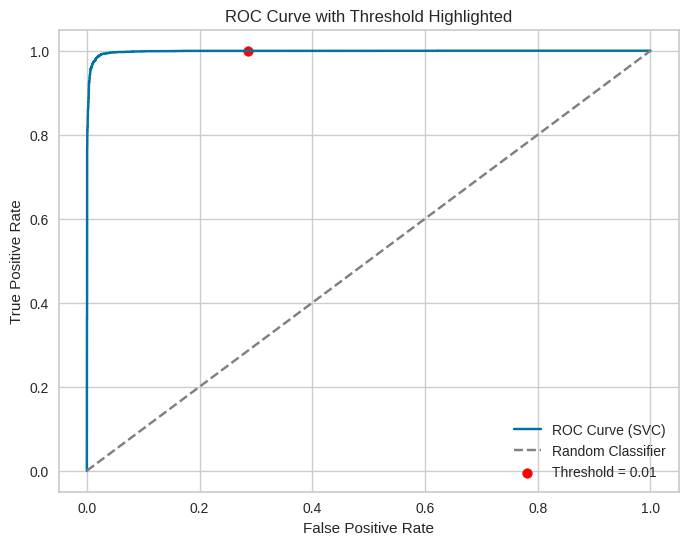

Threshold for FPR <= 30%: 0.013392535811572272


In [57]:
roc(y_train, clf_svc.predict_proba(X_train)[:, 1])

Logit

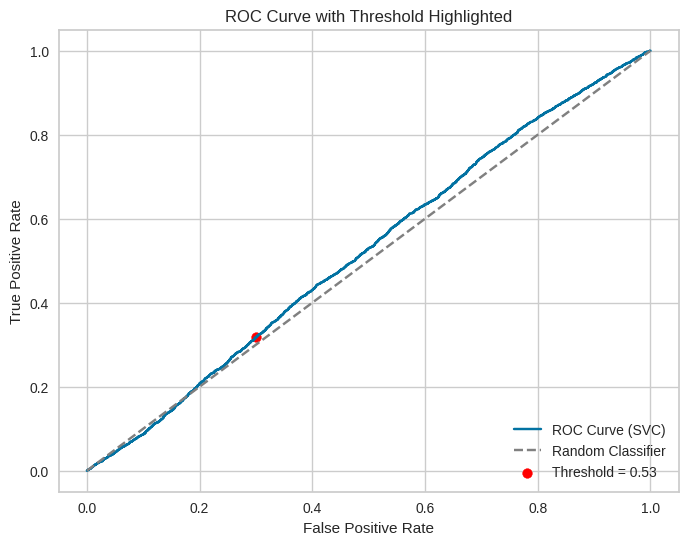

Threshold for FPR <= 30%: 0.5292691700921884


In [120]:
roc(y_train, clf.predict_proba(X_train)[:, 1])

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [61]:
from sklearn.multiclass import OneVsOneClassifier
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
label_encoder = LabelEncoder()
vectorizer = TfidfVectorizer(stop_words=None)
y = label_encoder.fit_transform(dataset['author'])
X =vectorizer.fit_transform(dataset['sentence'])

In [86]:
from sklearn.linear_model import LogisticRegression
parameters = {"estimator__max_iter": [100, 500, 1000], 'estimator__C': [0.001, 0.01, 0.1]}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svr = GridSearchCV(OneVsOneClassifier(LogisticRegression()), parameters, scoring='f1_micro', cv=2, verbose=2)
svr.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ........estimator__C=0.001, estimator__max_iter=100; total time=   3.1s
[CV] END ........estimator__C=0.001, estimator__max_iter=100; total time=   2.6s
[CV] END ........estimator__C=0.001, estimator__max_iter=500; total time=   2.8s
[CV] END ........estimator__C=0.001, estimator__max_iter=500; total time=   2.9s
[CV] END .......estimator__C=0.001, estimator__max_iter=1000; total time=   3.1s
[CV] END .......estimator__C=0.001, estimator__max_iter=1000; total time=   2.7s
[CV] END .........estimator__C=0.01, estimator__max_iter=100; total time=   3.0s
[CV] END .........estimator__C=0.01, estimator__max_iter=100; total time=   3.2s
[CV] END .........estimator__C=0.01, estimator__max_iter=500; total time=   3.6s
[CV] END .........estimator__C=0.01, estimator__max_iter=500; total time=   3.5s
[CV] END ........estimator__C=0.01, estimator__max_iter=1000; total time=   3.1s
[CV] END ........estimator__C=0.01, estimator__ma

GridSearchCV(cv=2, estimator=OneVsOneClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': [0.001, 0.01, 0.1],
                         'estimator__max_iter': [100, 500, 1000]},
             scoring='f1_micro', verbose=2)

Confusion matrix for train and test dataset


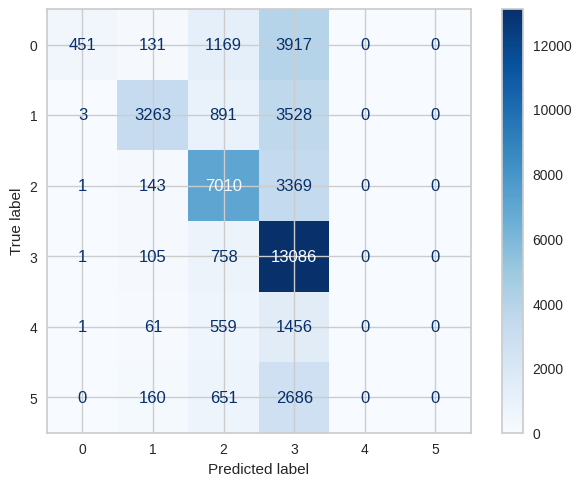

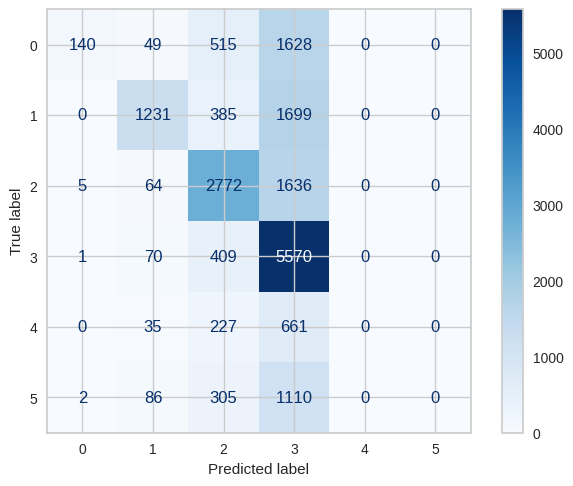

In [93]:
print("Confusion matrix for train and test dataset")
cm1 = ConfusionMatrixDisplay(confusion_matrix(y_train, svr.predict(X_train)), display_labels=np.arange(6))
cm1.plot(cmap='Blues')
cm2 = ConfusionMatrixDisplay(confusion_matrix(y_test, svr.predict(X_test)), display_labels=np.arange(6))
cm2.plot(cmap='Blues')

In [100]:
print("F1 score  = {0:6.2f}".format(f1_score(y_test, svr.predict(X_test), average='micro')))
print("Accuracy = {0:6.2f}".format(accuracy_score(y_test, svr.predict(X_test))))
print("Precision = {0:6.2f}".format(precision_score(y_test, svr.predict(X_test), average='micro')))

F1 score  =   0.52
Accuracy =   0.52
Precision =   0.52
